# Step One: Getting Data

### Download stock data and save it as csv

In [57]:
# Import requirements
import subprocess, os
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression, LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

In [58]:
def save_data(stock, freq='daily_adj', folder='stocks/'):
    # Call save_data_to_csv on stock
    base_wd = '/Users/jeffrey_yuan/Documents/8_Projects/algotrading/'
    os.chdir(base_wd+folder)
    print(subprocess.call(['python','save_data_to_csv.py', stock, freq]))
    os.chdir(base_wd)
    
def save_crypto_data(coin, market='USD', freq='daily', folder='stocks/'):
    # Call save_crypto_to_csv on crypto
    base_wd = '/Users/jeffrey_yuan/Documents/8_Projects/algotrading/'
    os.chdir(base_wd+folder)
    print(subprocess.call(['python','save_crypto_to_csv.py', coin, market, freq]))
    os.chdir(base_wd)
    
def get_stock(stock, freq='daily_adj', folder='stocks/', header='5. adjusted close'):
    # Get df from existing csv file
    csv_path = "{}{}_{}.csv".format(folder, stock, freq)
    df = pd.read_csv(csv_path)
    return df[header]

def get_crypto(coin, market='USD', freq='daily', folder='stocks/', header='4b. close (USD)'):
    # Get crypto df from existing csv file
    csv_path = "{}{}_{}_{}.csv".format(folder, coin, market, freq)
    df = pd.read_csv(csv_path)
    return df[header]

def ls(folder='/Users/jeffrey_yuan/Documents/8_Projects/algotrading/stocks/'):
    # Show files in directory to confirm new file
    print(os.getcwd())
    print(sorted(os.listdir(folder)))

def print_df(df):
    print(df)
    for col in df.columns:
        print(col)

# SMA Add Function
def add_sma(data, header, length, label):
    data[label] = data.rolling(window=length)[header].mean()

# EMA Add Function
def add_ema(data, header, length, label):
    data[label] = data.ewm(span=length)[header].mean()

# MACD Add Function
def add_macd(data, header, short, short_lab, long, long_lab, macd_lab):
    add_ema(data, header, short, short_lab)
    add_ema(data, header, long, long_lab)
    data[macd_lab] = data.loc[:,short_lab] - data.loc[:,long_lab]
    data.drop(columns=[short_lab, long_lab], axis=1, inplace=True)
    
# RSI Add Function
def add_rsi(data, header, length, label):
    data["Close Change"] = data[header] - data[header].shift()
    data["Up Changes"] = np.where(data["Close Change"] > 0, data["Close Change"], 0)
    data["Down Changes"] = np.where(data["Close Change"] < 0, abs(data["Close Change"]), 0)
    add_sma(data, "Up Changes", length, "Up Avg")
    add_sma(data, "Down Changes", length, "Down Avg")
    data[label] = 100 - (100 / (1 + (data["Up Avg"] / data["Down Avg"])))
    data.drop(columns=["Close Change", "Up Changes", "Down Changes", "Up Avg", "Down Avg"], axis=1, inplace=True)

In [64]:
# time intervals: every 10 entries over the last 101 entries
# These functions assume we already have csv files

# given a stock or crypto name, get the closing price
def find_close(stock, total_days = 101, day_interval = 10, typ = 'stock'):
    if typ == 'stock':
        closes = get_stock(stock)
    elif typ == 'crypto':
        closes = get_crypto(stock)
    return closes.iloc[0:total_days:day_interval]

# get the volume of the stock or crypto
def find_volume(stock, total_days = 101, day_interval = 10, typ = 'stock'):
    if typ == 'stock':
        vols = get_stock(stock, header = "6. volume")
    elif typ == 'crypto':
        vols = get_crypto(stock, header = "5. volume")
    return vols.iloc[0:total_days:day_interval]

# proportion change in price
def per_change(close):
    return (close - close.shift())/close.shift()

# df of all close prices in stock list
def all_closes(stock_list, total_days = 101, day_interval = 10, typ = 'stock'):
    if typ == 'stock':
        df = [get_stock(stock_list[0], header="date").iloc[0:total_days:day_interval][::-1]]
    elif typ == 'crypto':
        df = [get_crypto(stock_list[0], header="date").iloc[0:total_days:day_interval][::-1]]
    for s in stock_list:
        series = find_close(s, total_days = total_days, day_interval = day_interval, typ = typ)[::-1]
        series.name = s
        df.append(series)
    return pd.concat(df, axis = 1)     

# df of all proportion changes in stock list
def all_changes(stock_list, total_days = 101, day_interval = 10, typ = 'stock'):
    if typ == 'stock':
        df = [get_stock(stock_list[0], header="date").iloc[0:total_days:day_interval][::-1]]
    elif typ == 'crypto':
        df = [get_crypto(stock_list[0], header="date").iloc[0:total_days:day_interval][::-1]]
    for s in stock_list:
        series = find_close(s, total_days = total_days, day_interval = day_interval, typ = typ)[::-1]
        series.name = s
        df.append(per_change(series))
    return pd.concat(df, axis = 1)

# Set up strategy for evaluating features
- 10 stocks
- 100 day period
- Trade every 10 days
- Either buy, sell, or hold during a trade period
- Want to make a classifier including all of the features
- For each stock, for each trade period, find the percent change by the next trade period
- Combine values of all of the features to decide whether to buy or sell of hold

## STOCK LIST
- AAPL
- TSLA
- MSFT
- BAC
- JPM
- LAC
- SPY
- FB
- AMZN
- GOOGL

#### Others:
- VIM
- NVDA
- NIO
- CRM

In [65]:
# First get stock data
# Only 5 stocks at a time
# Split into 2 cells
## list1 = ["AAPL", "TSLA", "MSFT", "BAC", "JPM"]
##for s in list1:
##    save_data(s)

In [66]:
## # 2nd cell of 5 stocks
## list2 = ["LAC", "SPY", "FB", "AMZN", "GOOGL"]
## for s in list2:
##     save_data(s)

In [67]:
# Get stock indicators
def get_indicators(stock, total_days = 101, day_interval = 10, short = 12, long = 26, rsi_len = 14, typ = 'stock'):
    adj_total_days = total_days + long
    df = all_closes([stock], total_days = adj_total_days, day_interval = 1, typ = typ)
    header = stock
    short_lab = "{}-day EMA".format(short)
    long_lab = "{}-day EMA".format(long)
    macd_lab = "{} MACD".format(stock)
    add_macd(df, header, short, short_lab, long, long_lab, macd_lab)
    df["{} MACD Change".format(stock)] = df[macd_lab] - df[macd_lab].shift()
    rsi_lab = "{} RSI".format(stock)
    add_rsi(df, header, rsi_len, rsi_lab)
    df["{} RSI Change".format(stock)] = df[rsi_lab] - df[rsi_lab].shift()
    vol_lab = "{} Volume".format(stock)
    df[vol_lab] = find_volume(stock, total_days = adj_total_days, day_interval = 1, typ = typ)
    df["{} Volume Change".format(stock)] = df[vol_lab] - df[vol_lab].shift()
    df = df[::-1].iloc[0:total_days:day_interval]
    changes = all_changes([stock], total_days = total_days, day_interval = day_interval, typ = typ)
    df["{} Change".format(stock)] = changes[stock]
    return df

In [68]:
# Set features and target
#stock = "MSFT"
#typ = 'stock'
stock = "BTC"
typ = 'crypto'
lr_days = 1001
lr_num = (int)(lr_days / 10)
df = get_indicators(stock, total_days = lr_days, typ = typ)
features = df[["{} MACD".format(stock), 
               "{} MACD Change".format(stock), 
               "{} RSI".format(stock), 
               "{} RSI Change".format(stock), 
               "{} Volume".format(stock), 
               "{} Volume Change".format(stock)]][1:]
print(features)
change_lab = "{} Change".format(stock)

# binary target
bin_conds = [ df[change_lab] >= 0, df[change_lab] < 0]
bin_choices = ["buy", "sell"]
df["Binary Decision"] = np.select(bin_conds, bin_choices, default=np.NaN)
bin_target = df["Binary Decision"][:lr_num]


conditions = [ df[change_lab] >= 0.05, (df[change_lab] < 0.05) & (df[change_lab] > -0.05), df[change_lab] <= -0.05 ]
choices = ["buy", "hold", "sell"]
df["Decision"] = np.select(conditions, choices, default=np.NaN)
target = df["Decision"][:lr_num]
change_target = df[change_lab][:lr_num]

print(df)
print(target)
print(bin_target)

        BTC MACD  BTC MACD Change    BTC RSI  BTC RSI Change    BTC Volume  \
10   4313.844868      -141.635601  69.842612       -8.416247  68538.645370   
20   2724.220900       328.787704  84.482386        6.330080  52933.165751   
30   -753.752877       473.576588  51.709497       11.146223  66244.874920   
40   -633.106101      -461.973422  32.506115        5.437284  84534.080485   
50    302.186741      -253.211021  38.783329        1.613535  30440.408100   
..           ...              ...        ...             ...           ...   
950    35.410698        -4.416974  57.958118        0.133602  29349.537627   
960    35.987999         7.686670  65.790233        5.911414  28568.376124   
970    21.467782         1.823774  44.420312       -3.137117  24775.118830   
980    62.570355       -14.736126  53.004978      -29.449199  62224.186890   
990    11.034592        -2.302069        NaN             NaN  21753.501261   

     BTC Volume Change  
10        17109.710514  
20       -363

In [56]:
# Logistic Regression
X = features
y = bin_target
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')
model = lr.fit(X, y)
predictions = lr.predict(X)
print(predictions)
print("Score", lr.score(X, y)) 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

[-0.00257889 -0.00315707 -0.00595779  0.01336187 -0.02265248 -0.00244539
 -0.00076212  0.01146318  0.0083777   0.03481608 -0.00404991 -0.01251168
  0.02127475  0.01304885  0.00461095 -0.00628188 -0.01336148  0.02118743
  0.02034672  0.0257401  -0.00310283  0.02870565  0.02882144  0.00826002
  0.03103555  0.02117772  0.02910672  0.00181508  0.01413424  0.0102922
 -0.0124373   0.01116901  0.00329873  0.00896572 -0.00153913 -0.00603467
 -0.01418692  0.02936038  0.08550938  0.01394118 -0.00826853 -0.00214634
  0.00647598  0.01037647  0.02148277  0.01367941  0.03310997  0.01371545
  0.02288737  0.00964857  0.0070814   0.01087352  0.02213057  0.01734844
  0.00622417  0.03612161  0.01483586  0.00916944  0.03380346  0.00224791
  0.01349331  0.02675488  0.00526687  0.01719312  0.01685118  0.03501009
  0.00873632  0.01824188  0.02600821  0.05046014  0.01090535  0.01269027
  0.03330043  0.03949538  0.01765562  0.01562266  0.01509514  0.01227769
 -0.00178111  0.01519503  0.02220368  0.01438507  0.

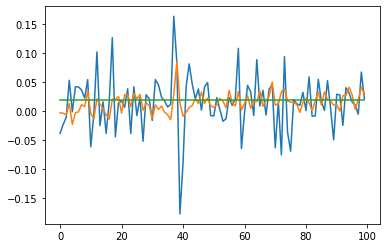

In [14]:
# Linear Regression
X = features
y = change_target
lm = LinearRegression()
model = lm.fit(X, y)
predictions = lm.predict(X)
print(predictions)
print("Score", lm.score(X, y))
print("Coef_", lm.coef_)
print("Intercept", lm.intercept_)
plt.plot(range(lr_num), change_target)
plt.plot(predictions)
plt.plot(range(lr_num), np.ones(lr_num)*0.02)
print(predictions[37:40])
print(change_target[37:40])

In [ ]:
# Get stock indicators (26-day MACD requires extra 26 days advance), prototype
stock_list = ["AAPL", "TSLA", "MSFT", "BAC", "JPM", "LAC", "SPY", "FB", "AMZN", "GOOGL"]
stock = stock_list[0]
df = all_closes([stock], total_days = 127, day_interval = 1)

print(df)
short = 12
long = 26
header = stock
short_lab = "{}-day EMA".format(short)
long_lab = "{}-day EMA".format(long)
macd_lab = "{} MACD".format(stock)
add_macd(df, header, short, short_lab, long, long_lab, macd_lab)
df["AAPL MACD Change"] = df[macd_lab] - df[macd_lab].shift()
print(df)
rsi_len = 14
rsi_lab = "{}-day RSI".format(rsi_len)
add_rsi(df, header, rsi_len, rsi_lab)
print(df)
df["AAPL Volume"] = find_volume(stock, total_days = 127, day_interval = 1)
print(df)
df = df[::-1].iloc[0:101:10]
print(df)
changes = all_changes([stock], total_days = 101, day_interval = 10)
df["{} Change".format(stock)] = changes[stock]
print(df)

In [ ]:
# make function for getting the information for one stock
# get final values for stock - percent change over each trade period
# make dataframe with all stocks together

# Prototype find_percent_change

stock_list = ["AAPL", "TSLA", "MSFT", "BAC", "JPM", "LAC", "SPY", "FB", "AMZN", "GOOGL"]

aapl = get_stock(stock_list[0])
times = get_stock(stock_list[0], header="date")
aapl_closes = aapl.iloc[0:101:10]
times_closes = times.iloc[0:101:10]
percents = (aapl_closes - aapl_closes.shift())/(aapl_closes - aapl_closes.shift())
print(aapl_closes)
print(percents)
#df = pd.concat([times_closes, aapl_closes], axis = 1)
#print(df)
print(all_closes(stock_list))
print(all_changes(stock_list))

In [ ]:
# Original prototype of indicators

# It is common to look at 50-, 100-, and 200-day moving averages
# If 50-day is above 200-day moving average, stock is bullish. A crossover to the downside is bearish.
length = 50
label = "{}-day SMA".format(length)
add_sma(rev_daily, header, length, label)
length = 100

header = "4. close"
length = 6
label = "{}-day EMA".format(length)
add_ema(rev_daily, header, length, label)

# MACD - Moving Average Convergence Divergence
# Calculated as MACD = EMA(short) - EMA(long)
short = 12
long = 26
header = "4. close"
short_lab = "{}-day EMA".format(short)
long_lab = "{}-day EMA".format(long)
add_ema(rev_daily, header, short, short_lab)
add_ema(rev_daily, header, long, long_lab)
rev_daily["MACD"] = rev_daily.loc[:,short_lab] - rev_daily.loc[:,long_lab]
print(rev_daily)
add_macd(rev_daily, header, short, short_lab, long, long_lab)

# MACD signal line
macd_sig_head = "MACD"
macd_sig_len = 9
macd_sig_lab = "9-day MACD EMA"
add_ema(rev_daily, macd_sig_head, macd_sig_len, macd_sig_lab)
print(rev_daily)

rev_daily["MACD Signals"] = rev_daily.loc[:,"MACD"] - rev_daily.loc[:,"9-day MACD EMA"]
#print(rev_daily)
rev_daily["MACD Bull"] = np.where((rev_daily["MACD Signals"] > 0) & (rev_daily["MACD Signals"].shift() < 0), 1, 0)
#print(rev_daily.loc[rev_daily["MACD bull"] == 1])
rev_daily["MACD Bear"] = np.where((rev_daily["MACD Signals"] < 0) & (rev_daily["MACD Signals"].shift() > 0), 1, 0)
#print(rev_daily.loc[rev_daily["MACD bear"] == 1])
print(rev_daily)

# Change in MACD
rev_daily["MACD Change"] = rev_daily["MACD"] - rev_daily["MACD"].shift()
print(rev_daily[["MACD", "9-day MACD EMA", "MACD Change"]])

# RSI - Relative Strength Indicator
# Magnitude of recent price changes, indicate overbought or oversold conditions
# Oscillator with values from 0 to 100
# Over-bought/over-valued: RSI >= 70
# Under-bought/under-valued: RSI <= 30
# Need change in price per period
rev_daily["Close Change"] = rev_daily["4. close"] - rev_daily["4. close"].shift()
rev_daily["Up Changes"] = np.where(rev_daily["Close Change"] > 0, rev_daily["Close Change"], 0)
rev_daily["Down Changes"] = np.where(rev_daily["Close Change"] < 0, abs(rev_daily["Close Change"]), 0)
rsi_length = 14
add_sma(rev_daily, "Up Changes", rsi_length, "Up Avg")
add_sma(rev_daily, "Down Changes", rsi_length, "Down Avg")
rev_daily["RSI"] = 100 - (100 / (1 + (rev_daily["Up Avg"] / rev_daily["Down Avg"])))
print(rev_daily)

# Test RSI Add Function
header = "4. close"
length = 14
label = "14-day RSI"
rev_daily = rev_daily.drop(columns=["Close Change", "Up Changes", "Down Changes", "Up Avg", "Down Avg", "14-day RSI"])
print("Before adding RSI")
print(rev_daily)
add_rsi(rev_daily, header, length, label)
print("\nAfter adding RSI")
print(rev_daily)

rev_daily["RSI Overbought"] = np.where(rev_daily["RSI"] >= 70, 1, 0)
rev_daily["RSI Oversold"] = np.where(rev_daily["RSI"] <= 30, 1, 0)
print(rev_daily)

In [ ]:
# All plots together
num_days = 100
end_index = rev_daily["index"][0]
start_index = end_index - num_days
rev_daily.iloc[start_index:end_index + 1].plot(y=["4. close", "12-day EMA", "26-day EMA"])
rev_daily.iloc[start_index:end_index + 1].plot(y=["MACD", "9-day MACD EMA"])
rev_daily.iloc[start_index:end_index + 1].plot(y=["MACD Bull", "MACD Bear"], kind="bar", color=["green", "red"])
rev_daily.iloc[start_index:end_index + 1].plot(y=["RSI"])
rev_daily.iloc[start_index:end_index + 1].plot(y=["RSI Overbought", "RSI Oversold"], kind="bar", color=["red", "green"])